In [4]:
import sys
import numpy as np
import scipy.stats
from matplotlib import pyplot as plt
import pandas as pd
import json
import numpy.fft
from decimal import Decimal
import math

%matplotlib inline

In [16]:
MAX_WINDOW = 10

def moving_average(data, _range):
    ret = np.cumsum(data, dtype=float)
    ret[_range:] = ret[_range:] - ret[:-_range]
    return ret[_range - 1:] / _range

def SMA(data, _range, slide):
    ret = moving_average(data, _range)[::slide]
    return list(ret)

def kurtosis(values):
    return scipy.stats.kurtosis(values)

def sucessive_slopes(vals):
    n = len(vals)
    diffs = []
    for i in range(n - 1):
        diffs.append((vals[i + 1] - vals[i]))
    return diffs

def roughness(vals):
    diff = sucessive_slopes(vals)
    return np.std(diff)


def smooth_simple(data, resolution=None):
    if resolution:
        paa_len = int(len(data) / resolution)
        if paa_len > 1:
            data = SMA(data, paa_len, paa_len)
    orig_kurt   = kurtosis(data)
    min_obj     = roughness(data)
    window_size = 1
    for w in range(2, int(len(data) / 10)):
        smoothed = SMA(data, w, 1)
        if kurtosis(smoothed) >= orig_kurt:
            r = roughness(smoothed)
            if r < min_obj:
                min_obj = r
                window_size = w
    return data, window_size

In [6]:
def plot(data, window_size):
    plt.clf()
    plt.figure()
    N = len(data)
    method_names = ["Original", "Smoothed"]
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    smoothed = SMA(data, window_size, 1)
    smoothed_range = range(int(window_size/2), int(window_size/2) + len(smoothed))
    ax1.set_xlim(0, len(data))
    ax1.plot(data, linestyle='-', linewidth=1.5)
    ax2.plot(smoothed_range, smoothed, linestyle='-', linewidth=1.5)
    axes = [ax1, ax2]
    for i in range(2):
        axes[i].get_xaxis().set_visible(False)
        axes[i].text(0.02, 0.8, "%s" %(method_names[i]),
            verticalalignment='center', horizontalalignment='left',
            transform=axes[i].transAxes, fontsize=25)

    fig.set_size_inches(16, 6)
    plt.tight_layout(w_pad=1)
    plt.show()

In [10]:
def load_csv(fname, input_column=1):
    import csv
    with open(fname, 'r') as ifh:
        icsv = csv.reader(ifh)
        if sys.version_info.major == 2:
            header = icsv.next()
        else:
            header = next(icsv)
        rows = list(icsv)

        try:
            data = [ float(x[input_column]) for x in rows ]
        except ValueError:
            print("couldn't convert input-column={0} float".format(input_column))
            if rows:
                print("first row:")
                for idx,x in enumerate(rows[0]):
                    print('  column {:3d}: {}'.format(idx,x))
            exit(1)
    return data

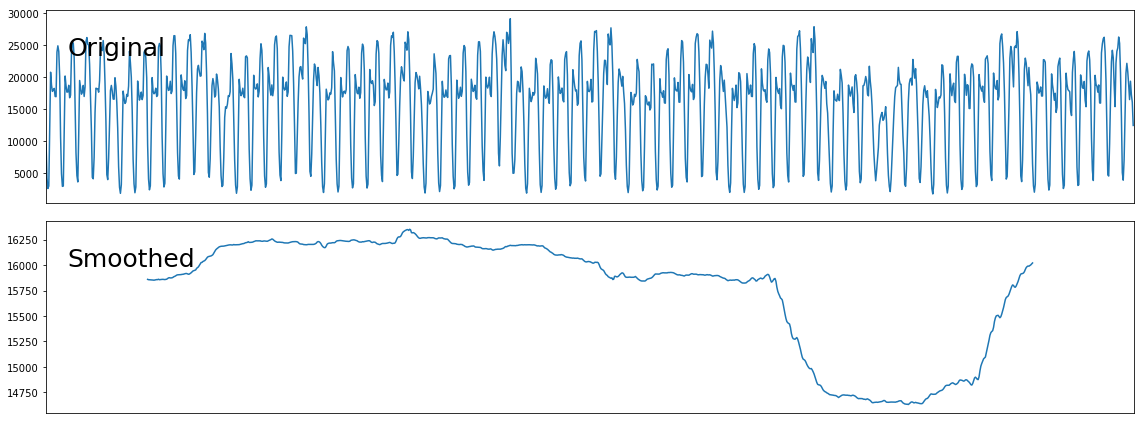

In [22]:
# Load data 
raw_data = load_csv('../Taxi.csv')
data, window_size = smooth_simple(raw_data, resolution=1000)
plot(data, window_size)